#### Test Configuration

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [ ]:
base_model = "distilbert-base-uncased"
test_model = "models/SemanticVAD_2_Cuda.pt"
NUM_LABELS = 2
device = "gpu"
test_data = "./test_data_clean_truncated.csv"
round = 50

In [ ]:
from transformers import DistilBertModel
import torch.nn as nn

class DistilBERTBackchannelScorer(nn.Module):
    def __init__(self, hidden_dim=768):
        super().__init__()
        self.encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # CLS token
        logits = self.classifier(pooled).squeeze(-1)  # shape: (batch_size,)
        loss = None
        if labels is not None:
            labels = labels.float()
            loss = nn.BCEWithLogitsLoss()(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

In [9]:
!file SemanticVAD_2_Cuda.pt

SemanticVAD_2_Cuda.pt: Zip archive data, at least v0.0 to extract, compression method=store


In [21]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTBackchannelScorer()
model.load_state_dict(torch.load(test_model, map_location=device))
model.to(device)
model.eval()

<ipython-input-21-58a7cb51645a>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(test_model, map_location=device))


DistilBERTBackchannelScorer(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
           

#### Construct Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CSVTestDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_length=128):
        df = pd.read_csv(csv_path)
        df = df.dropna(subset=["text"])
        df["text"] = df["text"].astype(str).str.replace(r"\[.*?\]", "", regex=True).str.strip()

        self.labels = df["labels"].tolist()
        self.encodings = tokenizer(
            df["text"].tolist(),
            truncation=True,
            padding="max_length",
            max_length=max_length
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encodings["input_ids"][idx])
        attention_mask = torch.tensor(self.encodings["attention_mask"][idx])
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_ids, attention_mask, label

In [13]:
def collate_fn(batch):
    input_ids = torch.stack([x[0] for x in batch])
    attention_mask = torch.stack([x[1] for x in batch])
    labels = torch.stack([x[2] for x in batch])
    return input_ids, attention_mask, labels

In [23]:
import pandas as pd
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
test_dataset = CSVTestDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)

In [24]:
import torch

if device == "cuda":
    print(f"Allocated VRAM: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max VRAM:       {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")

In [25]:
import psutil
process = psutil.Process()
print(f"RSS Memory: {process.memory_info().rss / 1024**2:.2f} MB")

RSS Memory: 1585.61 MB


In [26]:
import time
import psutil
import os
import torch
import numpy as np
from transformers.modeling_outputs import SequenceClassifierOutput

process = psutil.Process(os.getpid())

all_probs = []
all_preds = []
all_labels = []

memory_used = []
memory_cost = []
time_cost = []

sum_time = 0
sum_memory_cost = 0


with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i >= round:
            break
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        before = process.memory_info().rss
        start = time.time()

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits.view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        end = time.time()
        after = process.memory_info().rss

        mem_delta = after - before
        infer_time = end - start

        memory_used.append(before / 1024 / 1024)
        memory_cost.append(mem_delta / 1024 / 1024)
        time_cost.append(infer_time)

        sum_time += infer_time
        sum_memory_cost += mem_delta

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        for idx in range(len(labels)):
            print(f"Sample {i * len(labels) + idx} | True: {labels[idx].item()} | Pred: {preds[idx].item()} | Prob: {probs[idx]:.4f} | Time: {infer_time:.4f}s | ΔMem: {mem_delta / 1024 / 1024:.2f}MB")

avg_time = sum_time / len(test_loader.dataset)
avg_mem = sum_memory_cost / 1024 / 1024 / len(test_loader.dataset)

print("\n📊 Evaluation Summary")
print(f"🔢 Samples Evaluated: {len(test_loader.dataset)}")
print(f"🕒 Total Inference Time: {sum_time:.2f} s")
print(f"⏱️  Avg Inference Time per Sample: {avg_time:.4f} s")
print(f"🧠 Total Memory Cost: {sum_memory_cost / 1024 / 1024:.2f} MB")
print(f"🧠 Avg Memory per Sample: {avg_mem:.2f} MB")

Sample 0 | True: 0.0 | Pred: 0 | Prob: 0.0027 | Time: 0.5938s | ΔMem: 193.95MB
Sample 1 | True: 0.0 | Pred: 0 | Prob: 0.0057 | Time: 0.0052s | ΔMem: 0.00MB
Sample 2 | True: 0.0 | Pred: 1 | Prob: 0.9981 | Time: 0.0041s | ΔMem: 0.00MB
Sample 3 | True: 0.0 | Pred: 0 | Prob: 0.0028 | Time: 0.0047s | ΔMem: 0.00MB
Sample 4 | True: 0.0 | Pred: 1 | Prob: 0.9974 | Time: 0.0040s | ΔMem: 0.00MB
Sample 5 | True: 0.0 | Pred: 0 | Prob: 0.0026 | Time: 0.0043s | ΔMem: 0.00MB
Sample 6 | True: 0.0 | Pred: 0 | Prob: 0.0035 | Time: 0.0039s | ΔMem: 0.00MB
Sample 7 | True: 0.0 | Pred: 1 | Prob: 0.9979 | Time: 0.0039s | ΔMem: 0.00MB
Sample 8 | True: 0.0 | Pred: 0 | Prob: 0.0025 | Time: 0.0038s | ΔMem: 0.00MB
Sample 9 | True: 0.0 | Pred: 1 | Prob: 0.9732 | Time: 0.0071s | ΔMem: 0.00MB
Sample 10 | True: 0.0 | Pred: 0 | Prob: 0.0026 | Time: 0.0055s | ΔMem: 0.00MB
Sample 11 | True: 0.0 | Pred: 1 | Prob: 0.9982 | Time: 0.0042s | ΔMem: 0.00MB
Sample 12 | True: 0.0 | Pred: 0 | Prob: 0.0060 | Time: 0.0042s | ΔMem: 0

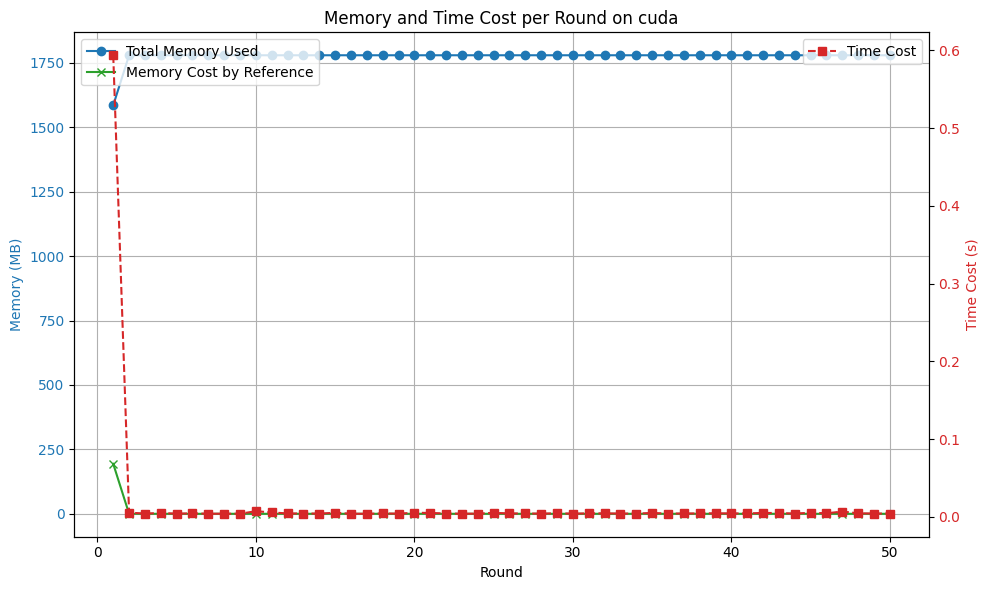

🧠 Total memory cost by reference: 193.95 MB
⏱️  Average time cost: 16.21 ms


In [27]:
import matplotlib.pyplot as plt

rounds = list(range(1, len(memory_used) + 1))
num_rounds = len(rounds)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Memory curves
color1 = 'tab:blue'
color2 = 'tab:green'
ax1.set_xlabel('Round')
ax1.set_ylabel('Memory (MB)', color=color1)
ax1.plot(rounds, memory_used, marker='o', color=color1, label='Total Memory Used')
ax1.plot(rounds, memory_cost, marker='x', color=color2, label='Memory Cost by Reference')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)
ax1.legend(loc='upper left')

# Time cost on second axis
ax2 = ax1.twinx()
color3 = 'tab:red'
ax2.set_ylabel('Time Cost (s)', color=color3)
ax2.plot(rounds, time_cost, marker='s', linestyle='--', color=color3, label='Time Cost')
ax2.tick_params(axis='y', labelcolor=color3)
ax2.legend(loc='upper right')

plt.title(f'Memory and Time Cost per Round on {device}')
fig.tight_layout()
plt.show()

# Stats summary
print(f"🧠 Total memory cost by reference: {sum_memory_cost / 1024 / 1024:.2f} MB")
print(f"⏱️  Average time cost: {(sum_time) / num_rounds * 1000:.2f} ms")

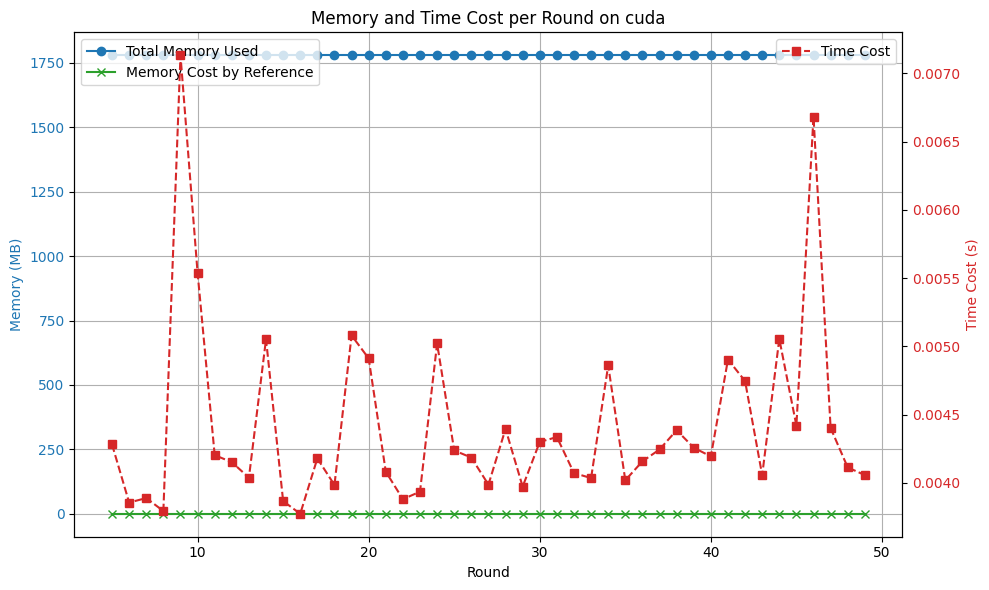

🧠 Total memory cost by reference: 0.00 MB
⏱️  Average time cost: 4.42 ms


In [ ]:
import matplotlib.pyplot as plt

warmup_round = 5  # skip first 5 rounds
rounds = list(range(warmup_round, len(memory_used)))

memory_used_trimmed = memory_used[warmup_round:]
memory_cost_trimmed = memory_cost[warmup_round:]
time_cost_trimmed = time_cost[warmup_round:]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Memory curves
color1 = 'tab:blue'
color2 = 'tab:green'
ax1.set_xlabel('Round')
ax1.set_ylabel('Memory (MB)', color=color1)
ax1.plot(rounds, memory_used_trimmed, marker='o', color=color1, label='Total Memory Used')
ax1.plot(rounds, memory_cost_trimmed, marker='x', color=color2, label='Memory Cost by Reference')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)
ax1.legend(loc='upper left')

# Time cost on second axis
ax2 = ax1.twinx()
color3 = 'tab:red'
ax2.set_ylabel('Time Cost (s)', color=color3)
ax2.plot(rounds, time_cost_trimmed, marker='s', linestyle='--', color=color3, label='Time Cost')
ax2.tick_params(axis='y', labelcolor=color3)
ax2.legend(loc='upper right')

plt.title(f'Memory and Time Cost per Round on {device}')
fig.tight_layout()
plt.show()

# Stats summary
print(f"🧠 Total memory cost by reference: {sum(memory_cost_trimmed):.2f} MB")
print(f"⏱️  Average time cost: {np.mean(time_cost_trimmed)*1000:.2f} ms")